In [1]:
# import modules
import uproot, sys, time, random, argparse, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *

# import trackingError function
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [5]:
file = uproot.open("/data/jlai/iris-hep/acts/thirdparty/OpenDataDetector/data/odd-material-maps.root")
file.keys()
file['SurfaceMaterial_vol2_bou0_lay2_app0_sen0/min;1']

<TH1F (version 3) at 0x7f6c4a2fc6e0>

In [8]:
file = uproot.open("/data/jlai/iris-hep/acts/thirdparty/OpenDataDetector/data/odd-material-maps.root")
hist = file["SurfaceMaterial_vol16_bou0_lay2_app0_sen0/min;1"]

# Get bin values and edges
values = hist.values()         # Bin contents (array of y values)
edges = hist.axis().edges()    # Bin edges (array of x bin edges)

# Optional: get bin centers
centers = 0.5 * (edges[:-1] + edges[1:])

# Print a few
for x, y in zip(centers, values):
    print(f"x = {x:.4f}, value = {y:.4e}")


x = 0.0000, value = -3.1416e+00
x = 1.0000, value = 4.0000e+01


In [7]:
hist = file["SurfaceMaterial_vol2_bou0_lay2_app0_sen0/max;1"]

# Get bin values and edges
values = hist.values()         # Bin contents (array of y values)
edges = hist.axis().edges()    # Bin edges (array of x bin edges)

# Optional: get bin centers
centers = 0.5 * (edges[:-1] + edges[1:])

# Print a few
for x, y in zip(centers, values):
    print(f"x = {x:.4f}, value = {y:.4e}")

x = 0.0000, value = 3.1416e+00
x = 1.0000, value = 4.0010e+03


In [29]:
def width_calc(key_t, key_x0):
    hist_t, hist_x0 = file[key_t], file[key_x0]
    values_t, values_x0 = hist_t.values(), hist_x0.values()

    # Mask only NaNs; keep zero values
    valid_mask = ~np.isnan(values_t) & ~np.isnan(values_x0) & values_x0 != 0
    valid_t = values_t[valid_mask]
    valid_x0 = values_x0[valid_mask]

    print(valid_t, valid_x0)

    # Compute ratio, set to 0 where either valid_t or valid_x0 is 0
    ratio = np.where((valid_t == 0), 0, valid_t / valid_x0)
    # ratio = np.where((valid_t == 0) | (valid_x0 == 0), 0, valid_t / valid_x0)

    if len(ratio) == 0:
        mean = 0
        std = 0
    else:
        mean = np.mean(ratio)
        std = np.std(ratio)

    print(f"Key: {key_t}, Mean: {mean:.6f}, Std Dev: {std:.6f}, Non-zero bins: {np.count_nonzero(valid_t)}\n")
    return mean


with open("/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/myODD3.txt", "w") as f:
    for i in [2]: 
        name = "SurfaceMaterial_vol2_bou0_lay{}_app0_sen0/{}"
        lay_num = i
        print(name.format(lay_num, "t"))
        mean = width_calc(name.format(lay_num, "t"), name.format(lay_num, "x0"))

SurfaceMaterial_vol2_bou0_lay2_app0_sen0/t


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [3]:
file = uproot.open("/data/jlai/iris-hep/acts/thirdparty/OpenDataDetector/data/odd-material-maps.root")
# test_int = 0.004
test_int = 0

def width_calc(key_t, key_x0):
    hist_t, hist_x0 = file[key_t], file[key_x0]
    values_t, values_x0 = hist_t.values(), hist_x0.values()

    # Mask only NaNs; keep zero values
    valid_mask = ~np.isnan(values_t) & ~np.isnan(values_x0)
    valid_t = values_t[valid_mask]
    valid_x0 = values_x0[valid_mask]

    # Compute ratio, set to 0 where either valid_t or valid_x0 is 0
    mean = np.sum(valid_t) / np.sum(valid_x0)
    std = 0
    # ratio = np.where((valid_t == 0), 0, valid_t / valid_x0)
    # ratio = np.where((valid_t == 0) | (valid_x0 == 0), 0, valid_t / valid_x0)

    # if len(ratio) == 0:
    #     mean = 0
    #     std = 0
    # else:
    #     mean = np.mean(ratio)
    #     std = np.std(ratio)

    print(f"Key: {key_t}, Mean: {mean:.6f}, Std Dev: {std:.6f}, Non-zero bins: {np.count_nonzero(valid_t)}\n")
    return mean


with open("/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/myODD3.txt", "w") as f:
    for i in [2]: 
        name = "SurfaceMaterial_vol2_bou0_lay{}_app0_sen0/{}"
        lay_num = i
        print(name.format(lay_num, "t"))
        mean = width_calc(name.format(lay_num, "t"), name.format(lay_num, "x0"))
        values = [mean,9999,9999,0.024]
        f.write(" ".join(str(v) for v in values) + "\n")

    position = [0.034, 0.07, 0.116, 0.172]
    for i in range(4):
        lay_num = 2*(i+1)
        name = "SurfaceMaterial_vol17_bou0_lay{}_app2_sen0/{}"
        print(name.format(lay_num, "t"))
        mean = width_calc(name.format(lay_num, "t"), name.format(lay_num, "x0"))
        values = [mean,0.015e-3,0.015e-3,position[i]-test_int]
        f.write(" ".join(str(v) for v in values) + "\n")

    position = [0.260, 0.360, 0.500, 0.660]
    for i in range(4):
        lay_num = 2*(i+1)
        name = "SurfaceMaterial_vol24_bou0_lay{}_app1_sen0/{}"
        print(name.format(lay_num, "t"))
        mean = width_calc(name.format(lay_num, "t"), name.format(lay_num, "x0"))
        values = [mean,0.043e-3,1.2e-3,position[i]-test_int]
        f.write(" ".join(str(v) for v in values) + "\n")

    position = [0.840, 1.020]
    for i in range(2):
        lay_num = 2*(i+1)
        name = "SurfaceMaterial_vol29_bou0_lay{}_app1_sen0/{}"
        print(name.format(lay_num, "t"))
        mean = width_calc(name.format(lay_num, "t"), name.format(lay_num, "x0"))
        values = [mean,0.072e-3,9999,position[i]-test_int]
        f.write(" ".join(str(v) for v in values) + "\n")

SurfaceMaterial_vol2_bou0_lay2_app0_sen0/t
Key: SurfaceMaterial_vol2_bou0_lay2_app0_sen0/t, Mean: 0.002307, Std Dev: 0.000000, Non-zero bins: 288

SurfaceMaterial_vol17_bou0_lay2_app2_sen0/t
Key: SurfaceMaterial_vol17_bou0_lay2_app2_sen0/t, Mean: 0.013836, Std Dev: 0.000000, Non-zero bins: 28800

SurfaceMaterial_vol17_bou0_lay4_app2_sen0/t
Key: SurfaceMaterial_vol17_bou0_lay4_app2_sen0/t, Mean: 0.013970, Std Dev: 0.000000, Non-zero bins: 28797

SurfaceMaterial_vol17_bou0_lay6_app2_sen0/t
Key: SurfaceMaterial_vol17_bou0_lay6_app2_sen0/t, Mean: 0.014321, Std Dev: 0.000000, Non-zero bins: 28800

SurfaceMaterial_vol17_bou0_lay8_app2_sen0/t
Key: SurfaceMaterial_vol17_bou0_lay8_app2_sen0/t, Mean: 0.014750, Std Dev: 0.000000, Non-zero bins: 28798

SurfaceMaterial_vol24_bou0_lay2_app1_sen0/t
Key: SurfaceMaterial_vol24_bou0_lay2_app1_sen0/t, Mean: 0.017120, Std Dev: 0.000000, Non-zero bins: 20998

SurfaceMaterial_vol24_bou0_lay4_app1_sen0/t
Key: SurfaceMaterial_vol24_bou0_lay4_app1_sen0/t, Mean

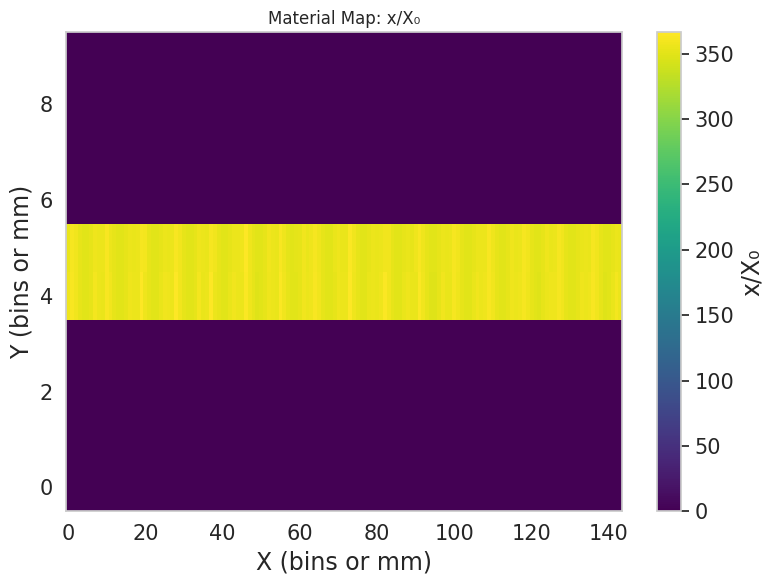

In [5]:
hist = file["SurfaceMaterial_vol2_bou0_lay2_app0_sen0/x0"]

# Convert to numpy arrays
values, edges_x, edges_y = hist.to_numpy()

# Plot with matplotlib
plt.figure(figsize=(8, 6))
plt.pcolormesh(edges_x, edges_y, values.T, cmap="viridis")
plt.colorbar(label="x/X₀")
plt.xlabel("X (bins or mm)")
plt.ylabel("Y (bins or mm)")
plt.title("Material Map: x/X₀")
plt.tight_layout()
plt.show()